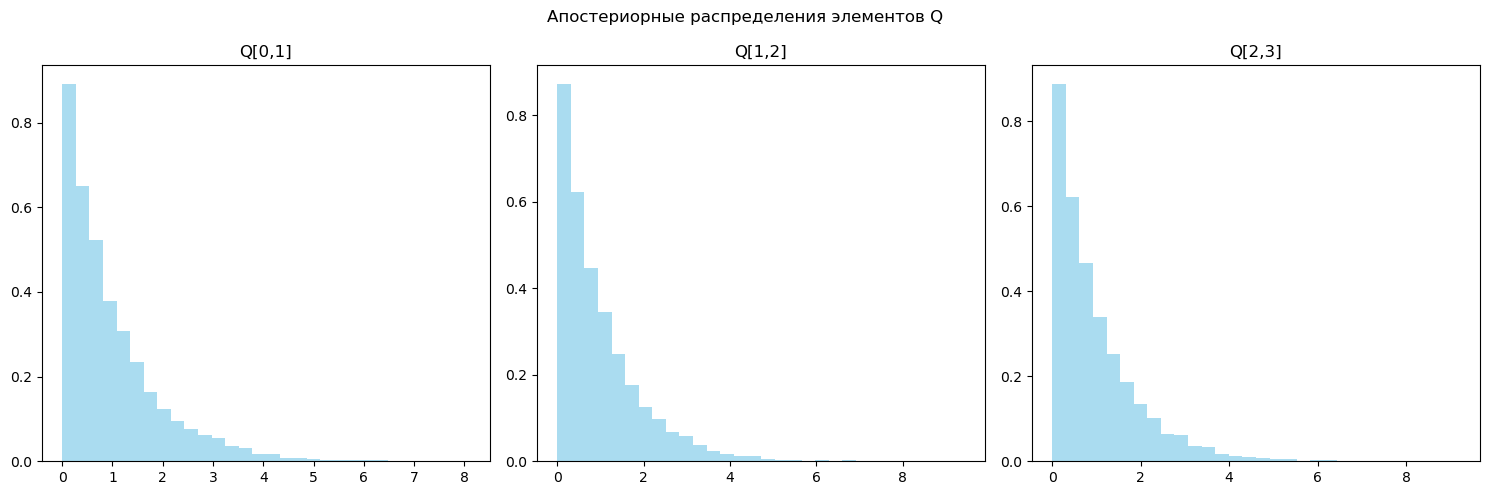

In [38]:
import numpy as np
from scipy.stats import expon, gamma
import matplotlib.pyplot as plt

# Настройки
n_states = 4  # количество состояний (например: AAA, AA, A, дефолт)
alpha = 1.0   # параметр Дирихле/гамма-распределения
beta = 1.0
num_iters = 10000
burn_in = 2000

# Начальная матрица Q
initial_q = np.array([
    [-0.3, 0.2, 0.1, 0.0],
    [0.0, -0.4, 0.3, 0.1],
    [0.0, 0.0, -0.5, 0.5],
    [0.0, 0.0, 0.0, 0.0]  # дефолт – поглощающее состояние
])

def simulate_jumps(q, max_time=100):
    current_state = 0
    jumps = []
    time = 0.0
    
    while time < max_time and current_state != n_states - 1:
        rate = -q[current_state, current_state]
        if rate <= 0:
            break

        dwell_time = expon.rvs(scale=1/rate)
        probs = q[current_state, :].copy()
        probs[current_state] = 0
        probs = np.maximum(probs, 0)
        if probs.sum() <= 0:
            break
        probs /= probs.sum()
        
        next_state = np.random.choice(n_states, p=probs)
        jumps.append((current_state, next_state, dwell_time))
        time += dwell_time
        current_state = next_state
    return jumps

def update_q(q, jumps):
    n_ij = np.zeros((n_states, n_states))
    r_i = np.zeros(n_states)
    
    for (i, j, t) in jumps:
        n_ij[i, j] += 1
        r_i[i] += t

    new_q = np.zeros_like(q)
    for i in range(n_states - 1):  # дефолт не обновляется
        for j in range(n_states):
            if i != j:
                new_alpha = alpha + n_ij[i, j]
                new_beta = beta + r_i[i]
                new_q[i, j] = gamma.rvs(new_alpha, scale=1/new_beta)
        new_q[i, i] = -np.sum(new_q[i, :])
    return new_q

# BMCMC-итерации
samples = []
q = initial_q.copy()

for it in range(num_iters):
    jumps = simulate_jumps(q)
    q = update_q(q, jumps)
    
    if it >= burn_in:
        samples.append(q.copy())

# Пример: гистограммы некоторых элементов Q
samples = np.array(samples)
plt.figure(figsize=(15, 5))
for idx, (i, j) in enumerate([(0, 1), (1, 2), (2, 3)]):
    plt.subplot(1, 3, idx + 1)
    plt.hist(samples[:, i, j], bins=30, density=True, alpha=0.7, color='skyblue')
    plt.title(f"Q[{i},{j}]")
plt.suptitle("Апостериорные распределения элементов Q")
plt.tight_layout()
plt.show()


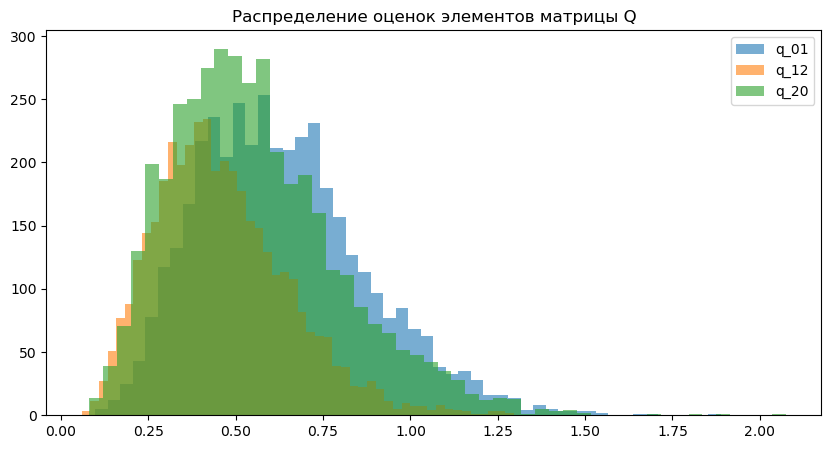

In [42]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

def bmcmc_simulation(N, R, alpha, beta, num_samples=4000):
    """
    Байесовская MCMC-оценка матрицы переходных вероятностей.
    
    :param N: матрица наблюдаемых переходов (размер m x m)
    :param R: вектор времени пребывания в состояниях (размер m)
    :param alpha: априорные параметры формы гамма-распределения (размер m x m)
    :param beta: априорные параметры масштаба гамма-распределения (размер m)
    :param num_samples: количество итераций MCMC
    :return: массив сгенерированных матриц Q
    """
    m = N.shape[0]  # Количество состояний
    samples = np.zeros((num_samples, m, m))
    
    for s in range(num_samples):
        Q = np.zeros((m, m))
        for i in range(m):
            for j in range(m):
                if i != j:
                    shape = N[i, j] + alpha[i, j]
                    scale = 1 / (R[i] + beta[i])
                    Q[i, j] = np.random.gamma(shape, scale)
            Q[i, i] = -np.sum(Q[i, :])  # Диагональные элементы
        samples[s] = Q
    
    return samples

m = 3 # Число состояний
N = np.array([[0, 5, 3], [2, 0, 4], [3, 1, 0]])  # Количество переходов
R = np.array([10, 12, 8])  # Время пребывания в состояниях
alpha = np.ones((m, m)) * 2  # Априорное значение alpha
beta = np.ones(m) * 1  # Априорное значение beta

samples = bmcmc_simulation(N, R, alpha, beta)

plt.figure(figsize=(10, 5))
plt.hist(samples[:, 0, 1], bins=50, alpha=0.6, label='q_01')
plt.hist(samples[:, 1, 2], bins=50, alpha=0.6, label='q_12')
plt.hist(samples[:, 2, 0], bins=50, alpha=0.6, label='q_20')
plt.legend()
plt.title("Распределение оценок элементов матрицы Q")
plt.show()


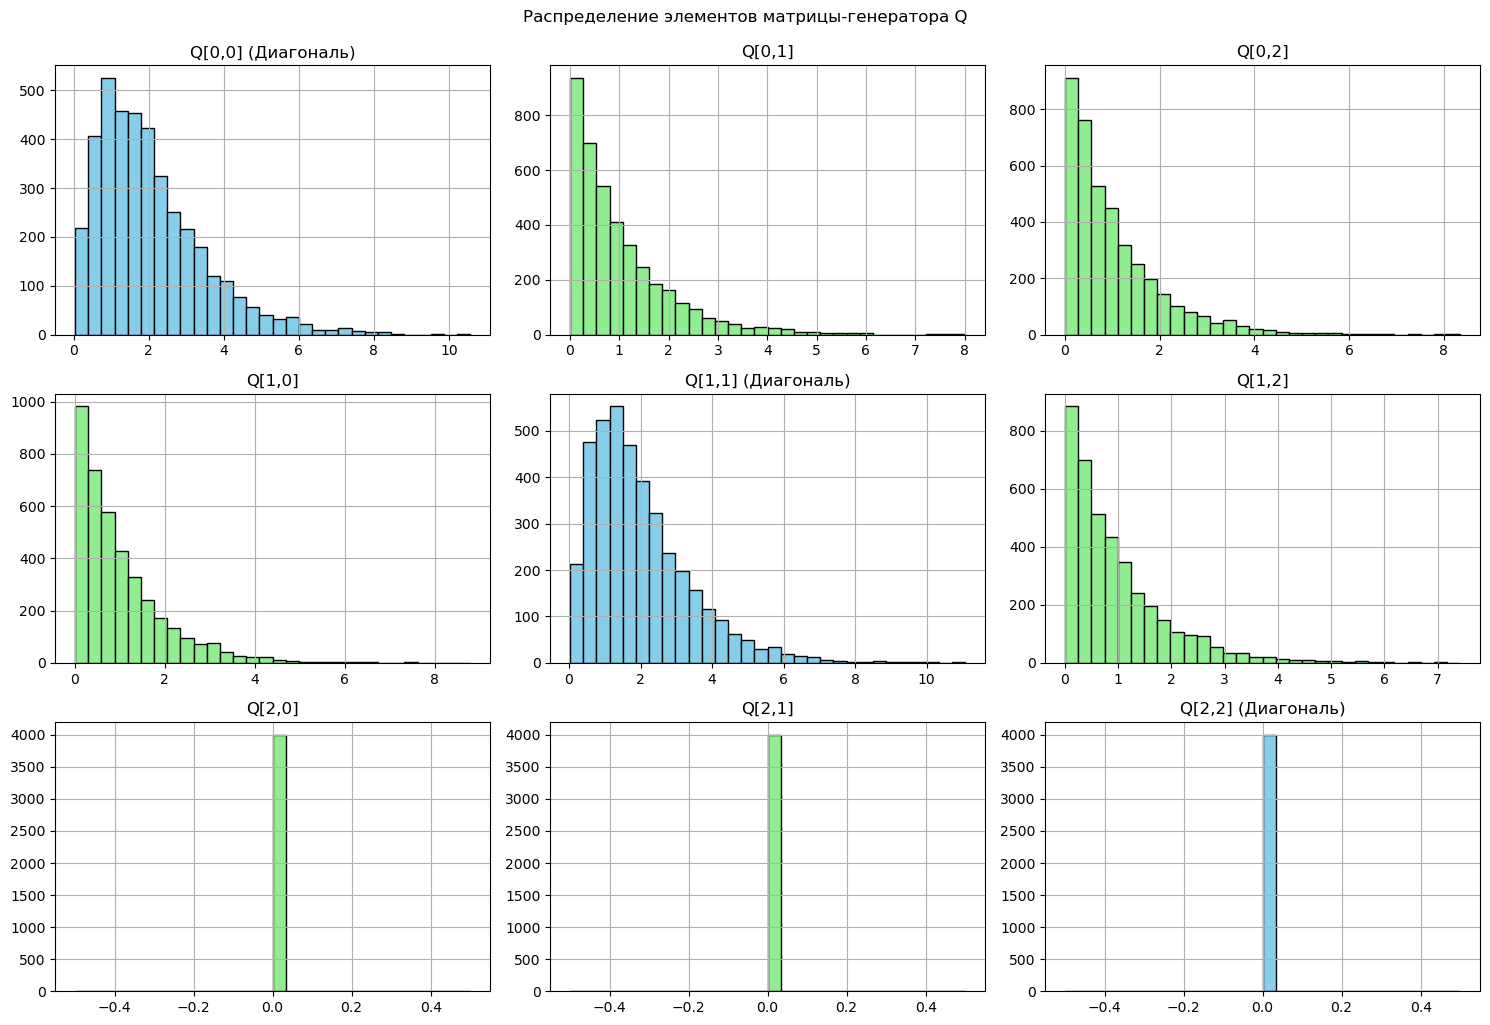

тоговая оценка матрицы Q:
[[-2.048  1.025  1.022]
 [ 1.024 -2.006  0.983]
 [ 0.     0.     0.   ]]


In [40]:
import numpy as np
from scipy.stats import gamma, expon
import matplotlib.pyplot as plt

# param
states = ['A', 'B', 'D']
n_states = len(states)
burn_in = 1000
iterations = 4000
alpha = 1.0
beta = 1.0

# Inicialization Q
def initialize_q():
    q = np.zeros((n_states, n_states))
    for i in range(n_states - 1):
        for j in range(n_states):
            if i != j:
                q[i, j] = gamma.rvs(alpha, scale=1/beta)
        q[i, i] = -np.sum(q[i, :])
    return q

# Simulation
def simulate_jumps(q, max_time=100):
    current_state = 0
    jumps = []
    time = 0.0
    
    while time < max_time and current_state != n_states - 1:
        rate = -q[current_state, current_state]
        if rate <= 0:
            break
            
        dwell_time = expon.rvs(scale=1/rate)
        probs = q[current_state, :].copy()
        probs[current_state] = 0
        probs = np.maximum(probs, 0)
        if probs.sum() <= 0:
            break
        probs /= probs.sum()
        
        next_state = np.random.choice(n_states, p=probs)
        jumps.append((current_state, next_state, dwell_time))
        time += dwell_time
        current_state = next_state
    return jumps

# Update Q
def update_q(q, jumps):
    n_ij = np.zeros((n_states, n_states))
    r_i = np.zeros(n_states)
    
    for (i, j, t) in jumps:
        n_ij[i, j] += 1
        r_i[i] += t
    
    new_q = np.zeros_like(q)
    for i in range(n_states - 1):
        for j in range(n_states):
            if i != j:
                new_alpha = alpha + n_ij[i, j]
                new_beta = beta + r_i[i]
                new_q[i, j] = gamma.rvs(new_alpha, scale=1/new_beta)
        new_q[i, i] = -np.sum(new_q[i, :])
    return new_q

# MCMC
# np.random.seed(42)
q_chain = []
current_q = initialize_q()

for step in range(burn_in + iterations):
    jumps = simulate_jumps(current_q)
    if len(jumps) > 0:
        current_q = update_q(current_q, jumps)
    
    if step >= burn_in and len(jumps) > 0:
        q_chain.append(current_q.copy())

# Main body
if q_chain:
    q_chain = np.array(q_chain)
    fig, axes = plt.subplots(n_states, n_states, figsize=(15, 10))
    
    for i in range(n_states):
        for j in range(n_states):
            ax = axes[i, j]
            if i == j:
                ax.set_title(f'Q[{i},{j}] (Диагональ)')
                ax.hist(-q_chain[:, i, i], bins=30, color='skyblue', edgecolor='black')
            else:
                ax.set_title(f'Q[{i},{j}]')
                ax.hist(q_chain[:, i, j], bins=30, color='lightgreen', edgecolor='black')
            ax.grid(True)
    
    plt.tight_layout()
    plt.suptitle('Распределение элементов матрицы-генератора Q', y=1.02)
    plt.show()
    
    # Вывод итоговой оценки
    final_q = np.mean(q_chain, axis=0)
    print("тоговая оценка матрицы Q:")
    print(np.round(final_q, 3))
else:
    print("Не удалось получить оценки.")

Рассмотрим PyMVC

In [4]:
pip install pymc arviz


  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.9/517.9 kB 3.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 5.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 5.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 5.0 MB/s eta 0:00:00a 0:00:01
  Created wheel for cons: filename=cons-0.4.6-py3-none-any.whl size=9098 sha256=c3954903c7c4e9669d8fad559f94e7576a40c213134898480da17fb8f3463d01
  Stored in directory: /Users/danilalipatov/Library/Caches/pip/wheels/95/8f/45/fe0a5b5e232401da571d514eb545833fbe220993ac8336c94e
  Created wheel for logical-unification: filename=lo

In [3]:
import numpy as np
import pymc as pm
import arviz as az

In [35]:
# Кол-во наблюдаемых переходов между рейтингами (упрощённые данные)
N = np.array([
    [50, 10,  0,  0,  0],
    [5,  40, 5,  0,  0],
    [0,   5, 45, 5,  0],
    [0,   0, 5, 40, 5],
    [0,   0, 0,  5, 50]
])

K = N.shape[0]

with pm.Model() as model:
    # Матрица переходов: каждая строка — Dirichlet
    P = pm.Dirichlet("P", a=np.ones_like(N) + N, shape=N.shape)

    # Наблюдаемые переходы
    for i in range(K):
        pm.Multinomial(f"obs_{i}", n=N[i].sum(), p=P[i], observed=N[i])

    trace = pm.sample(2000, tune=1000, chains=3, target_accept=0.8)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [P]


Output()

Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 44 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
P[0, 0]  0.808  0.035   0.741    0.873        0.0    0.000    6955.0   
P[0, 1]  0.168  0.033   0.107    0.232        0.0    0.000    7040.0   
P[0, 2]  0.008  0.008   0.000    0.023        0.0    0.000    3815.0   
P[0, 3]  0.008  0.008   0.000    0.022        0.0    0.000    3836.0   
P[0, 4]  0.008  0.008   0.000    0.023        0.0    0.000    6114.0   
P[1, 0]  0.105  0.030   0.051    0.161        0.0    0.000    8585.0   
P[1, 1]  0.772  0.041   0.693    0.846        0.0    0.001    8498.0   
P[1, 2]  0.104  0.029   0.051    0.157        0.0    0.000    9130.0   
P[1, 3]  0.010  0.010   0.000    0.027        0.0    0.000    4139.0   
P[1, 4]  0.010  0.009   0.000    0.027        0.0    0.000    5378.0   
P[2, 0]  0.009  0.008   0.000    0.024        0.0    0.000    3326.0   
P[2, 1]  0.095  0.027   0.047    0.146        0.0    0.000    9244.0   
P[2, 2]  0.792  0.038   0.720    0.862        0.0    0.001    9384.0   
P[2, 3]  0.096  0.027   0.048    0.149        0.0    0.000    9562.0   
P[2, 4]  0.009  0.008   0.000    0.024        0.0    0.000    4012.0   
P[3, 0]  0.009  0.010   0.000    0.026        0.0    0.000    2886.0   
P[3, 1]  0.010  0.010   0.000    0.027        0.0    0.000    3637.0   
P[3, 2]  0.105  0.030   0.053    0.163        0.0    0.000    8130.0   
P[3, 3]  0.772  0.041   0.696    0.850        0.0    0.000    7415.0   
P[3, 4]  0.105  0.030   0.052    0.162        0.0    0.000    6206.0   
P[4, 0]  0.009  0.008   0.000    0.023        0.0    0.000    4651.0   
P[4, 1]  0.009  0.008   0.000    0.024        0.0    0.000    4486.0   
P[4, 2]  0.009  0.009   0.000    0.025        0.0    0.000    3653.0   
P[4, 3]  0.096  0.027   0.046    0.146        0.0    0.000    6486.0   
P[4, 4]  0.878  0.030   0.820    0.930        0.0    0.000    6236.0   

         ess_tail  r_hat  
P[0, 0]    4072.0    1.0  
P[0, 1]    3864.0    1.0  
P[0, 2]    2326.0    1.0  
P[0, 3]    2560.0    1.0  
P[0, 4]    3665.0    1.0  
P[1, 0]    5216.0    1.0  
P[1, 1]    4163.0    1.0  
P[1, 2]    5096.0    1.0  
P[1, 3]    3143.0    1.0  
P[1, 4]    3450.0    1.0  
P[2, 0]    2738.0    1.0  
P[2, 1]    4657.0    1.0  
P[2, 2]    3827.0    1.0  
P[2, 3]    4449.0    1.0  
P[2, 4]    2766.0    1.0  
P[3, 0]    2139.0    1.0  
P[3, 1]    2698.0    1.0  
P[3, 2]    3953.0    1.0  
P[3, 3]    5107.0    1.0  
P[3, 4]    3680.0    1.0  
P[4, 0]    2450.0    1.0  
P[4, 1]    2411.0    1.0  
P[4, 2]    2100.0    1.0  
P[4, 3]    5259.0    1.0  
P[4, 4]    4199.0    1.0

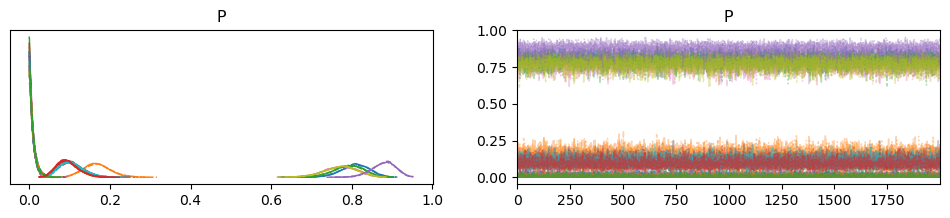

In [36]:
az.plot_trace(trace, var_names=["P"])
az.summary(trace, var_names=["P"])


In [37]:
P_mean = trace.posterior["P"].mean(dim=["chain", "draw"]).values


In [38]:
P_mean

array([[0.80818741, 0.16799124, 0.00799902, 0.0078956 , 0.00792672],
       [0.10456875, 0.77212509, 0.10413353, 0.00967165, 0.00950098],
       [0.00852348, 0.09543164, 0.79186182, 0.09561084, 0.00857223],
       [0.00934527, 0.00972   , 0.10460866, 0.77152752, 0.10479855],
       [0.00860753, 0.0087089 , 0.00863385, 0.09582085, 0.87822888]])

array([[<Axes: title={'center': 'P'}>, <Axes: title={'center': 'P'}>]],
      dtype=object)

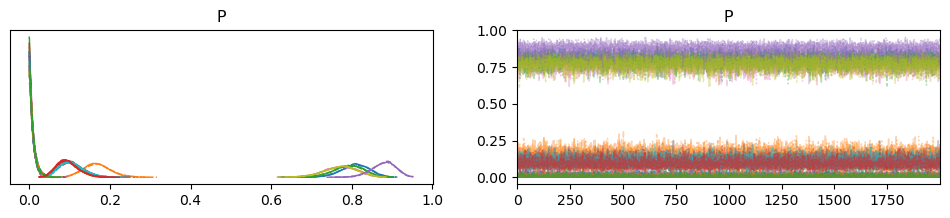

In [39]:
import arviz as az
az.plot_trace(trace)

/opt/anaconda3/lib/python3.11/site-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (25), generating only 20 plots
  warnings.warn(


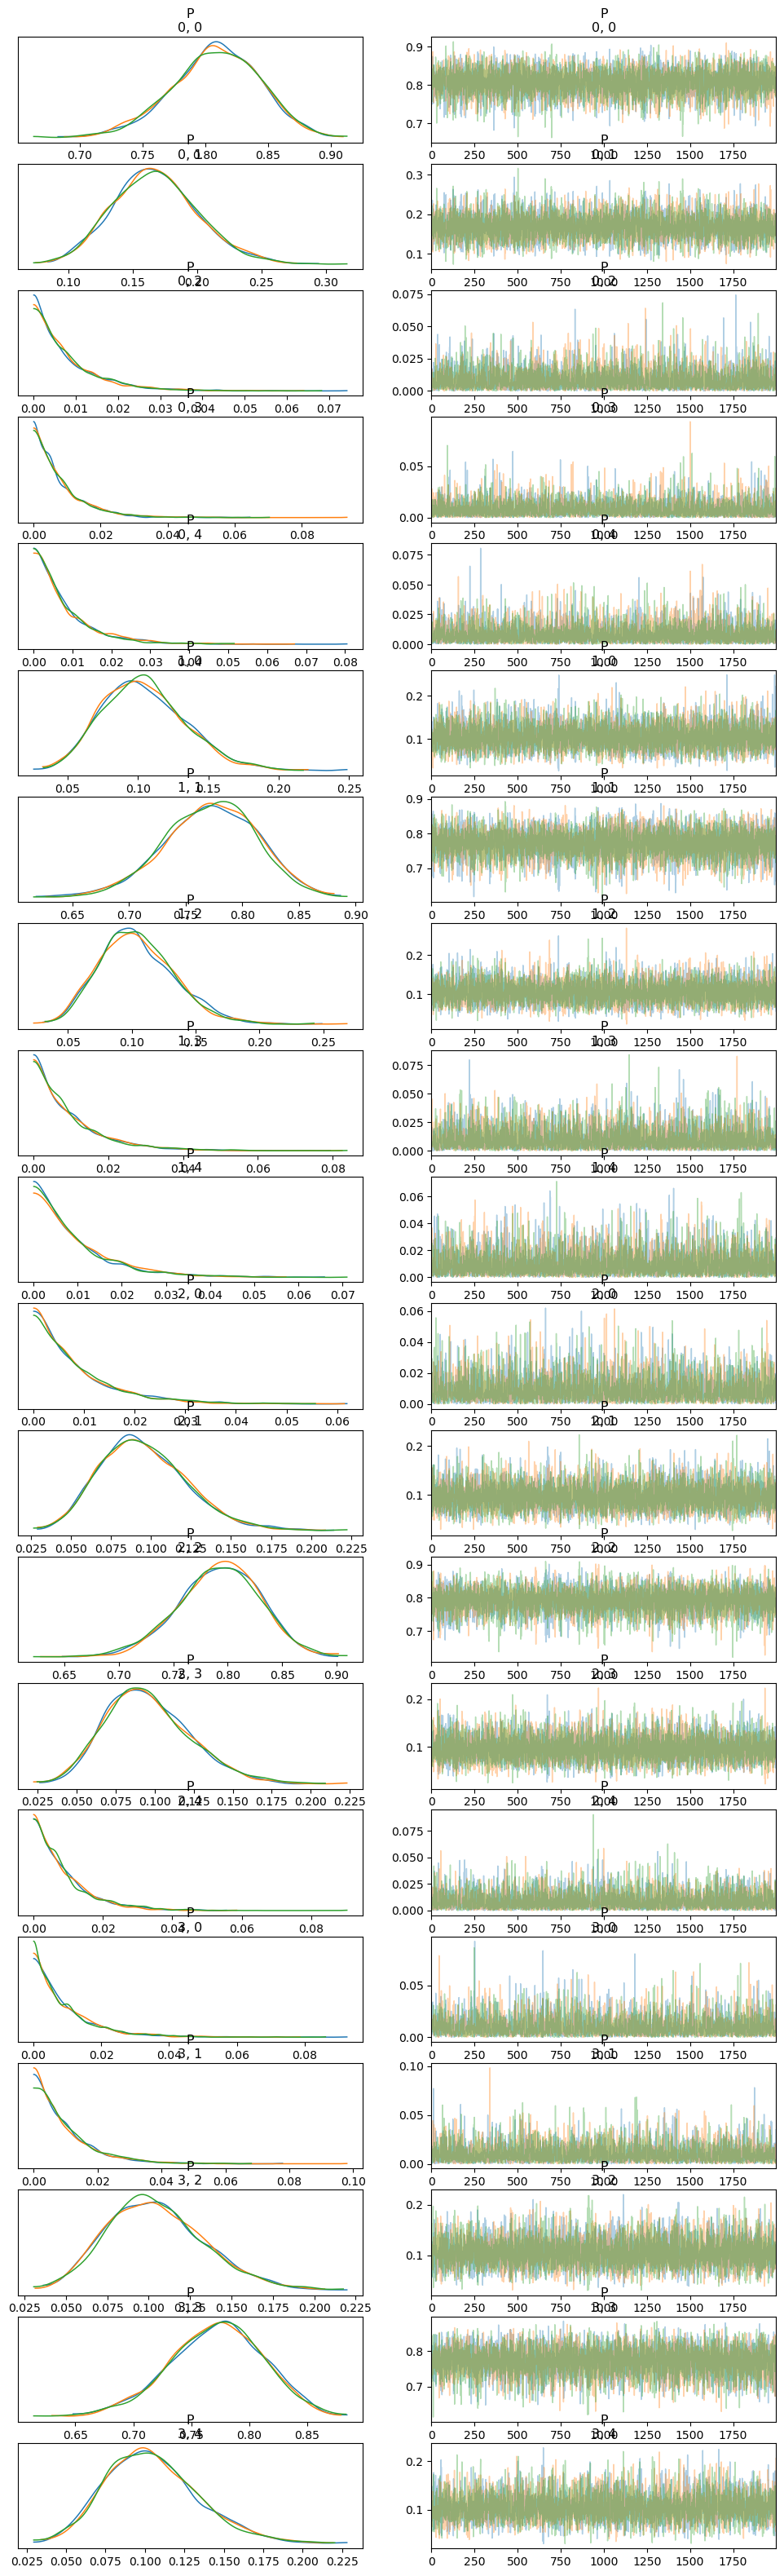

In [45]:
# Предположим, что trace — это результат работы pm.sample()
axes = az.plot_trace(trace, compact=False)

# Добавим легенду вручную к каждому подграфику
for ax_group in axes:
    for ax in ax_group:
        handles, labels = ax.get_legend_handles_labels()
        if handles:
            ax.legend(handles, labels, title="Цепи", loc="best")

График для перехода: AAA → AAA


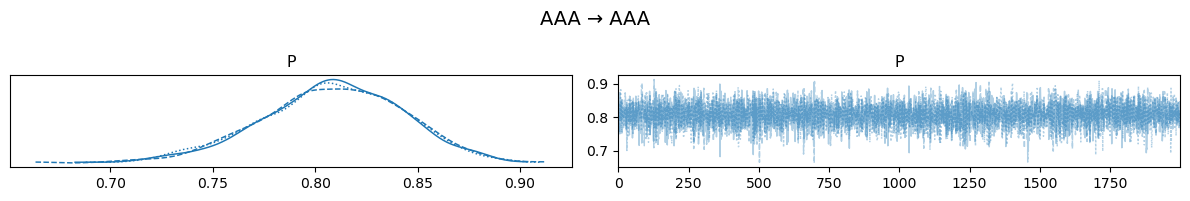

График для перехода: AAA → AA


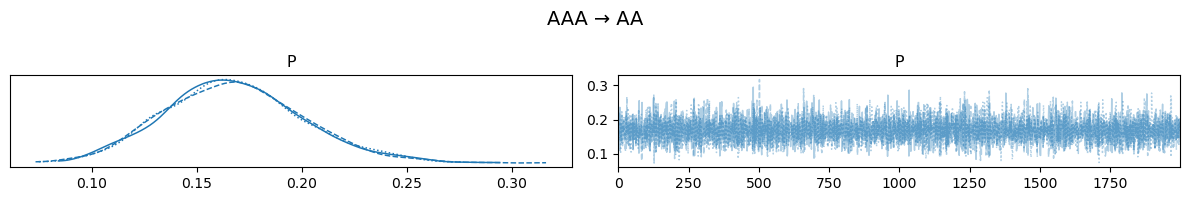

График для перехода: AAA → A


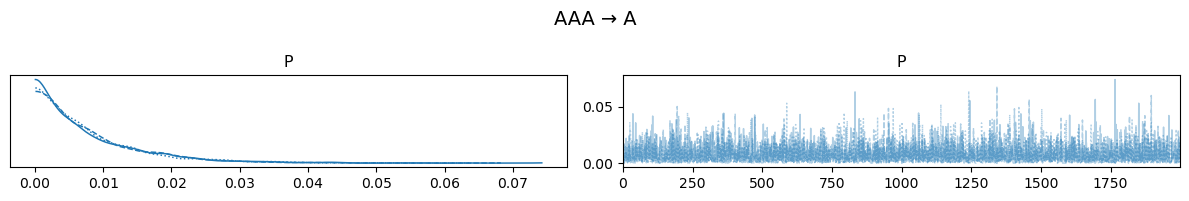

График для перехода: AAA → BBB


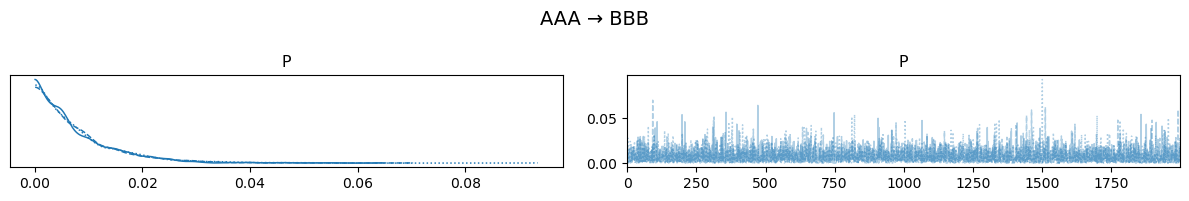

График для перехода: AAA → BB


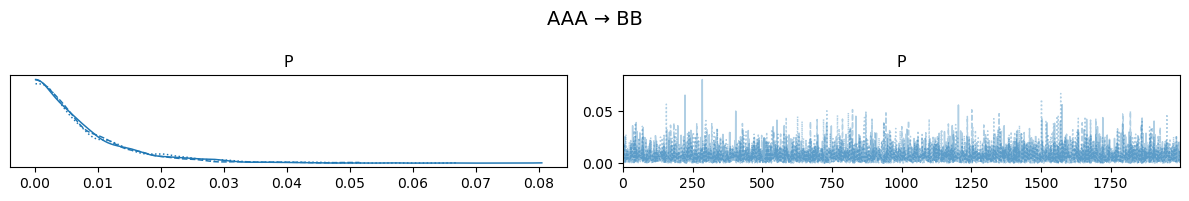

График для перехода: AAA → B


KeyError: 'Coords should follow mapping format {coord_name:[dim1, dim2]}. Check that coords structure is correct and dimensions are valid. "not all values found in index \'P_dim_1\'"'

In [51]:
import arviz as az
import matplotlib.pyplot as plt

# Названия рейтингов в нужном порядке (можно изменить под твои)
rating_names = ["AAA", "AA", "A", "BBB", "BB", "B", "CCC", "D"]

# Размерность матрицы P (N x N)
n_ratings = len(rating_names)

# Перебираем все пары (i, j) и визуализируем каждый элемент P[i, j]
for i in range(n_ratings):
    for j in range(n_ratings):
        transition_label = f"{rating_names[i]} → {rating_names[j]}"
        print(f"График для перехода: {transition_label}")
        
        # Создаем отдельную фигуру для каждого перехода
        az.plot_trace(
            trace, 
            var_names=["P"], 
            coords={"P_dim_0": [i], "P_dim_1": [j]},
        )
        plt.suptitle(transition_label, fontsize=14)
        plt.tight_layout()
        plt.show()


In [53]:
print(trace.posterior)


<xarray.Dataset>
Dimensions:  (chain: 3, draw: 2000, P_dim_0: 5, P_dim_1: 5)
Coordinates:
  * chain    (chain) int64 0 1 2
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999
  * P_dim_0  (P_dim_0) int64 0 1 2 3 4
  * P_dim_1  (P_dim_1) int64 0 1 2 3 4
Data variables:
    P        (chain, draw, P_dim_0, P_dim_1) float64 0.85 0.1306 ... 0.8429
Attributes:
    created_at:                 2025-05-09T08:15:30.474699+00:00
    arviz_version:              0.21.0
    inference_library:          pymc
    inference_library_version:  5.22.0
    sampling_time:              43.70681309700012
    tuning_steps:               1000


График для перехода: P[0 → 0]


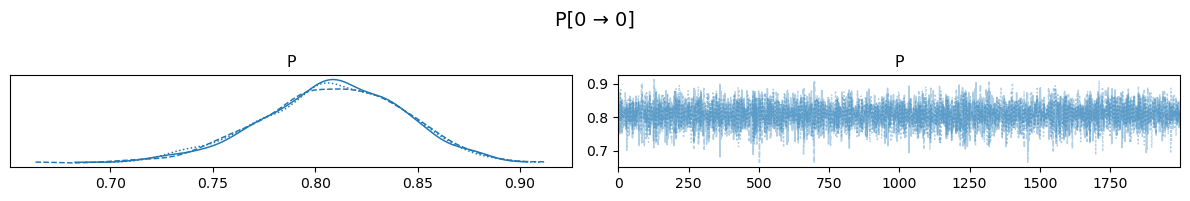

График для перехода: P[0 → 1]


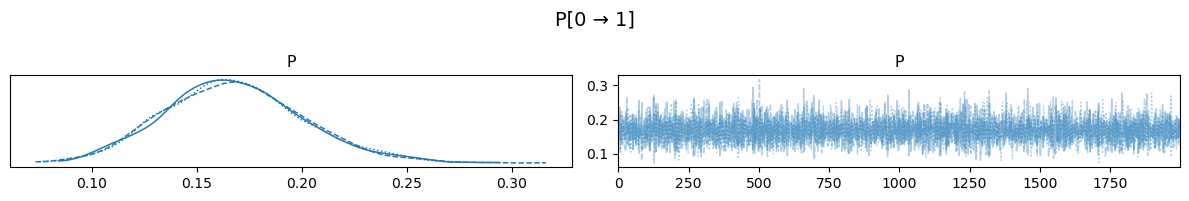

График для перехода: P[0 → 2]


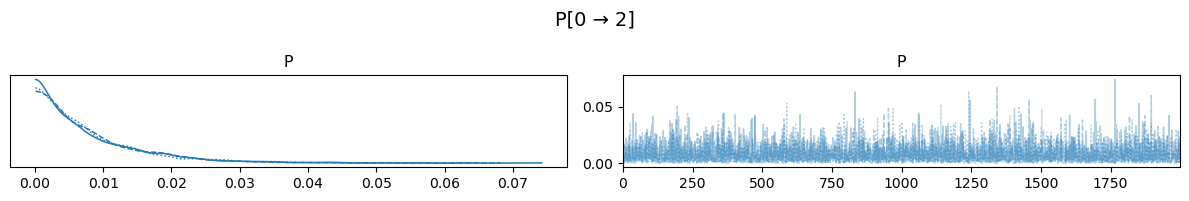

График для перехода: P[0 → 3]


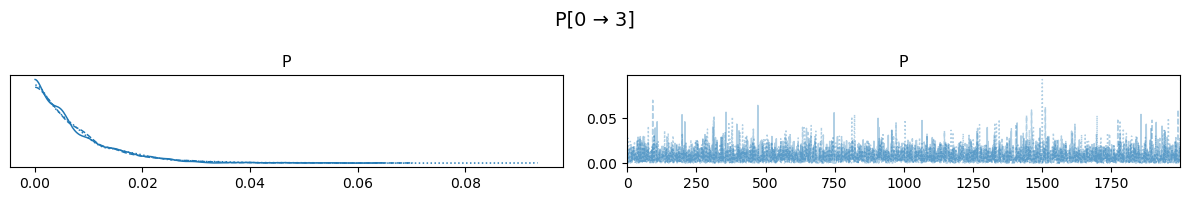

График для перехода: P[0 → 4]


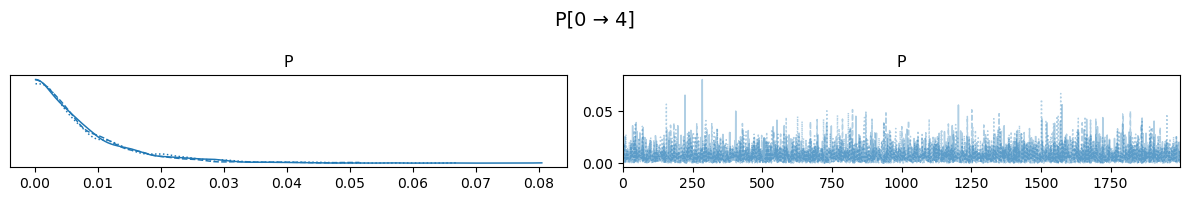

График для перехода: P[1 → 0]


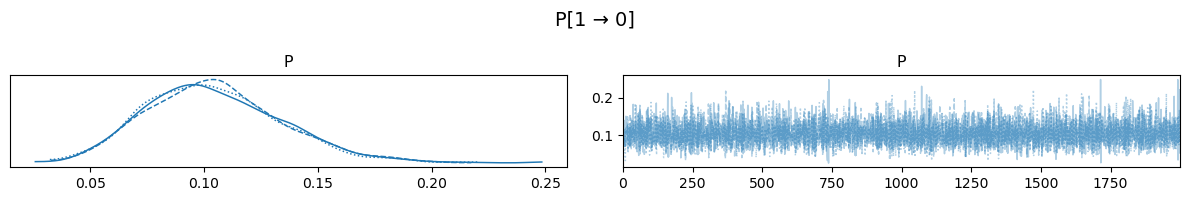

График для перехода: P[1 → 1]


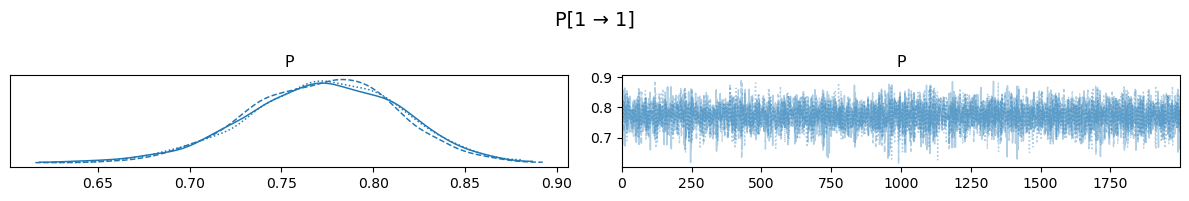

График для перехода: P[1 → 2]


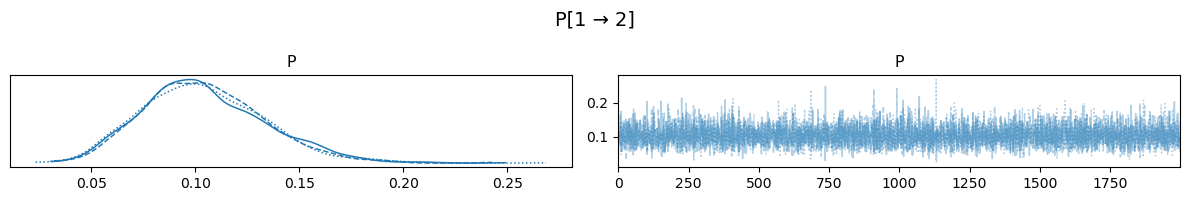

График для перехода: P[1 → 3]


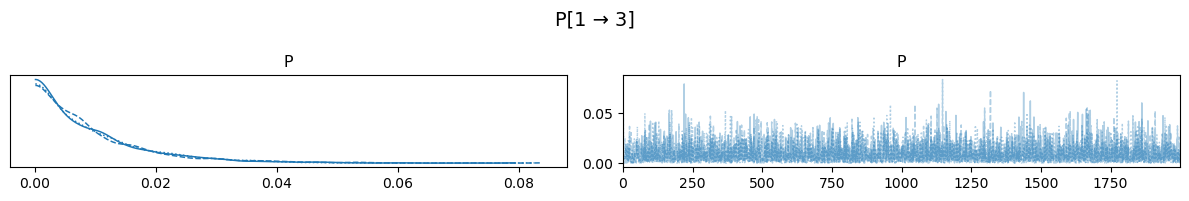

График для перехода: P[1 → 4]


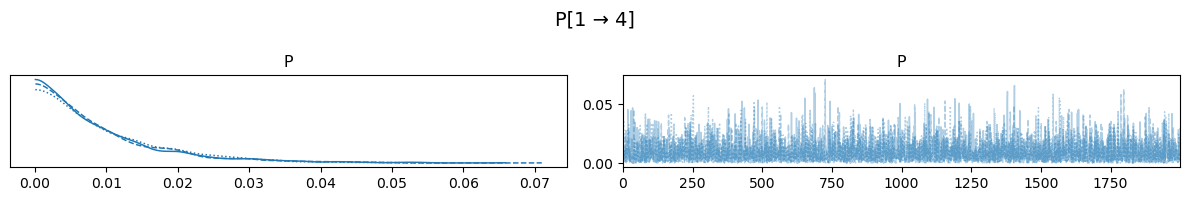

График для перехода: P[2 → 0]


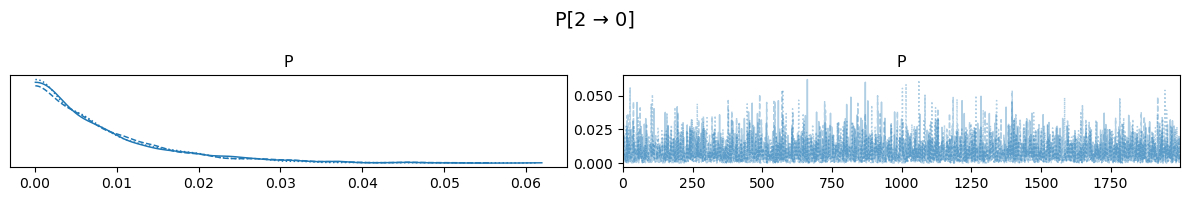

График для перехода: P[2 → 1]


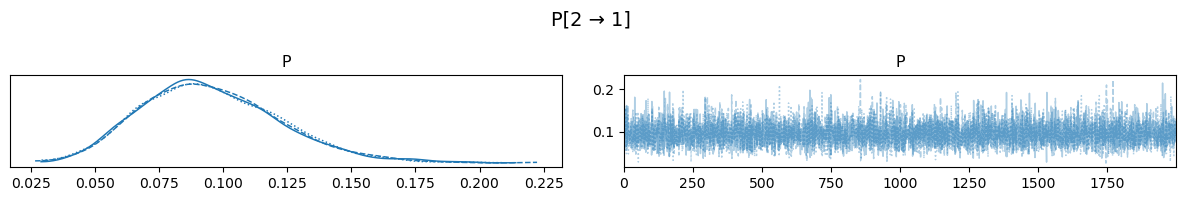

График для перехода: P[2 → 2]


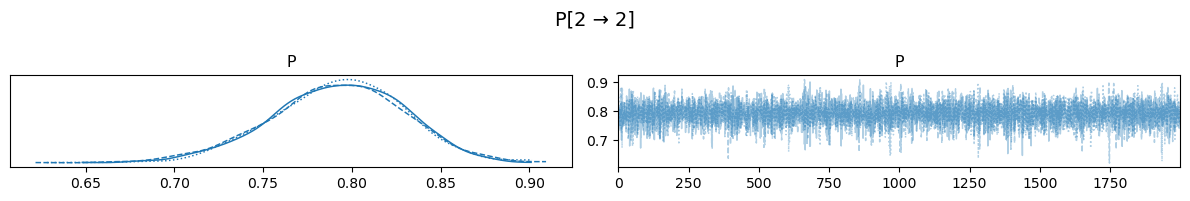

График для перехода: P[2 → 3]


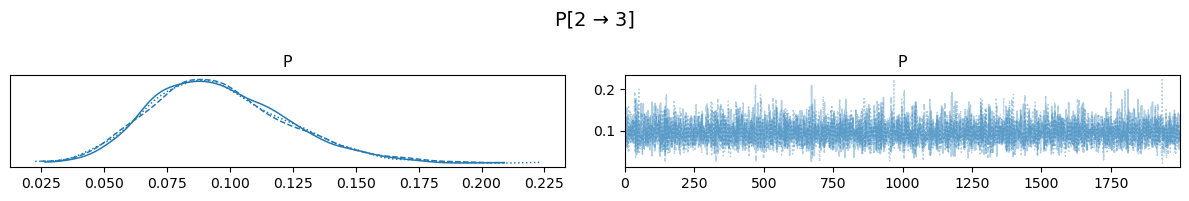

График для перехода: P[2 → 4]


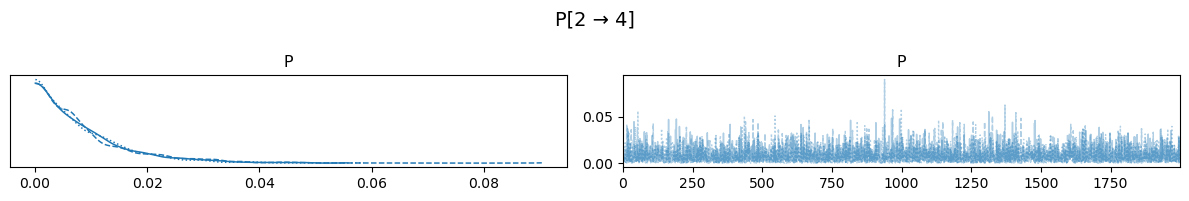

График для перехода: P[3 → 0]


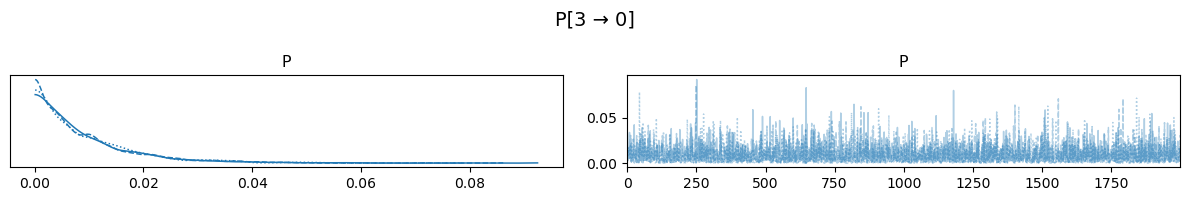

График для перехода: P[3 → 1]


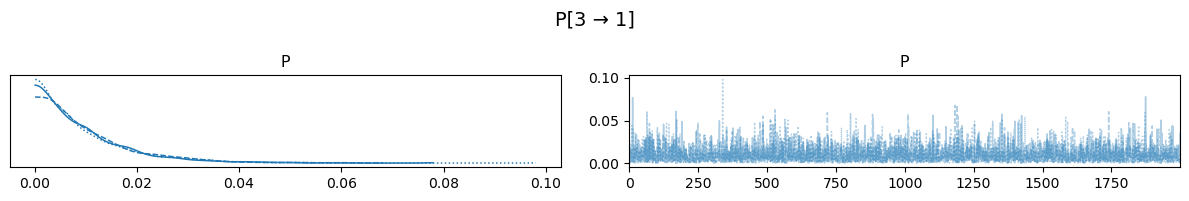

График для перехода: P[3 → 2]


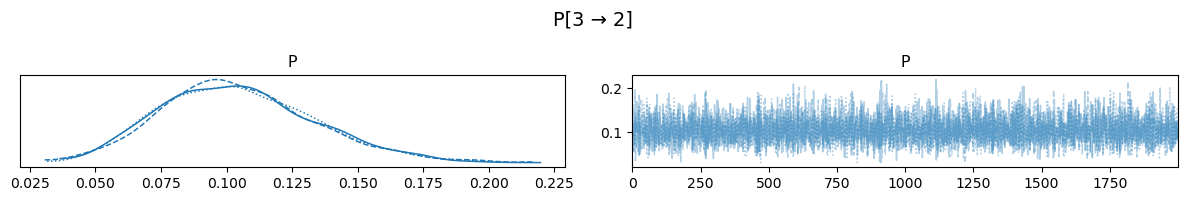

График для перехода: P[3 → 3]


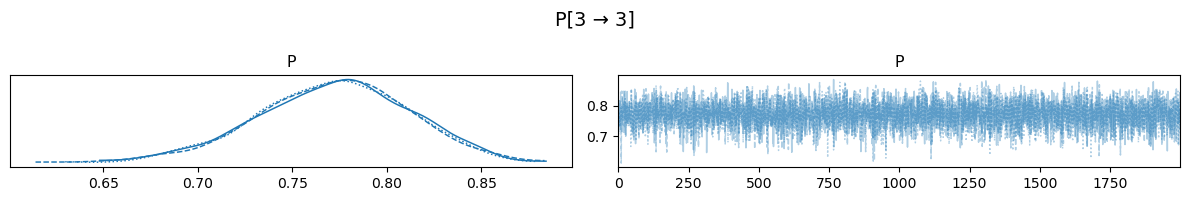

График для перехода: P[3 → 4]


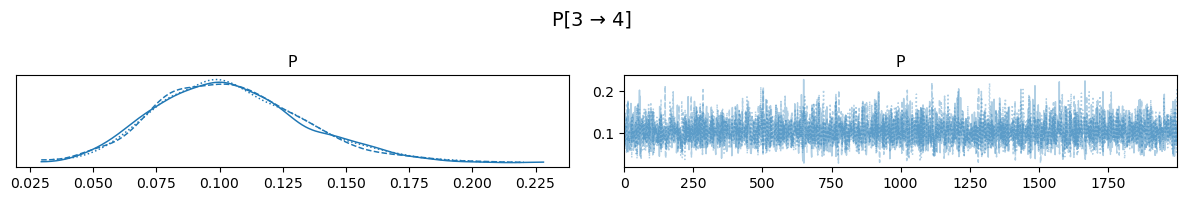

График для перехода: P[4 → 0]


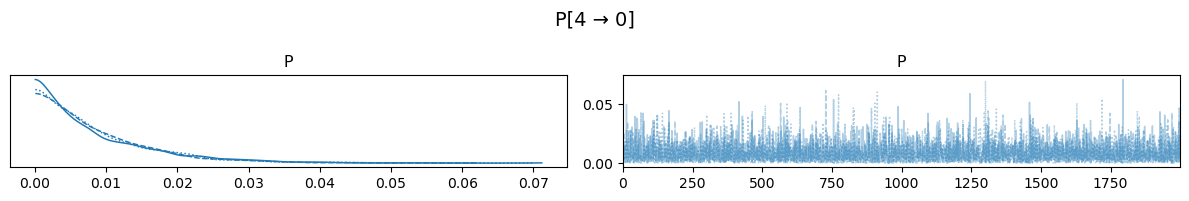

График для перехода: P[4 → 1]


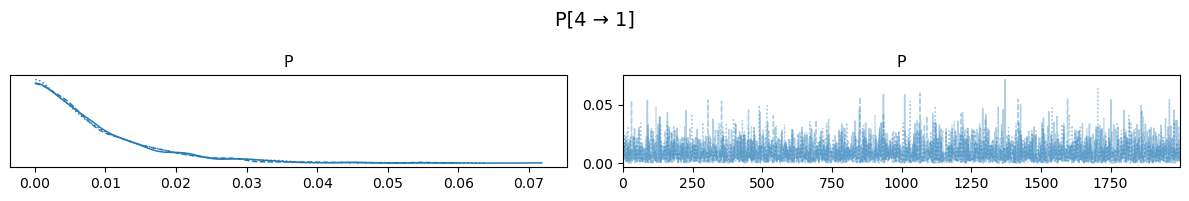

График для перехода: P[4 → 2]


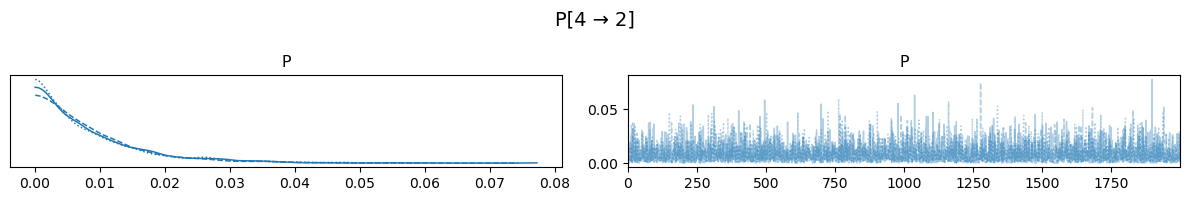

График для перехода: P[4 → 3]


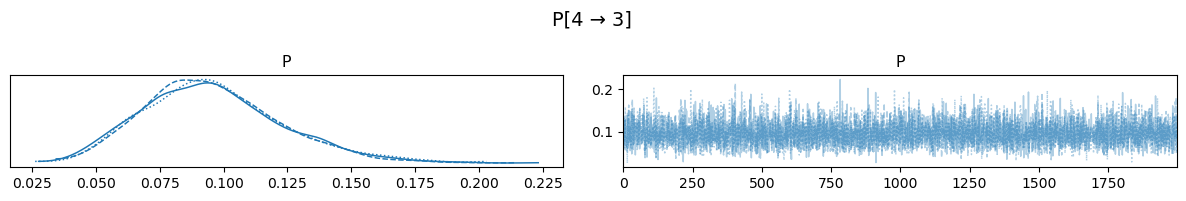

График для перехода: P[4 → 4]


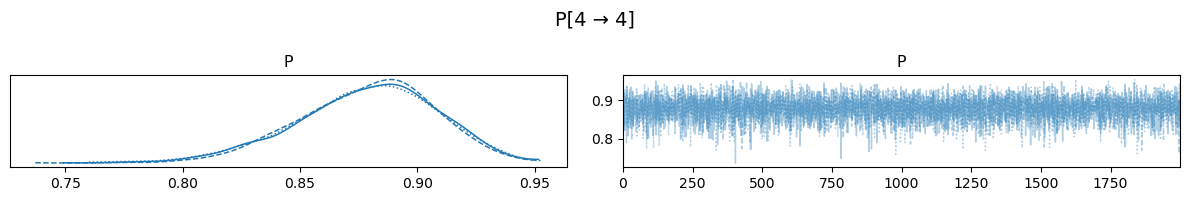

In [55]:

# Визуализация трейсов всех переходов P[i, j]
for i in range(5):
    for j in range(5):
        transition_label = f"P[{i} → {j}]"
        print(f"График для перехода: {transition_label}")
        
        # Создаем фигуру и отображаем трейсы
        az.plot_trace(
            trace, 
            var_names=["P"], 
            coords={"P_dim_0": [i], "P_dim_1": [j]},
        )
        
        plt.suptitle(transition_label, fontsize=14)
        plt.tight_layout()
        plt.show()

In [57]:
az.summary(trace, var_names=["P"], round_to=4)


mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   ess_bulk  \
P[0, 0]  0.8082  0.0350  0.7410   0.8732     0.0004   0.0005  6955.1606   
P[0, 1]  0.1680  0.0330  0.1075   0.2315     0.0004   0.0005  7039.5701   
P[0, 2]  0.0080  0.0080  0.0000   0.0226     0.0001   0.0002  3815.2090   
P[0, 3]  0.0079  0.0080  0.0000   0.0218     0.0001   0.0002  3835.8596   
P[0, 4]  0.0079  0.0081  0.0000   0.0228     0.0001   0.0002  6114.1009   
P[1, 0]  0.1046  0.0301  0.0513   0.1609     0.0003   0.0004  8584.7841   
P[1, 1]  0.7721  0.0410  0.6926   0.8462     0.0004   0.0006  8498.3808   
P[1, 2]  0.1041  0.0293  0.0511   0.1572     0.0003   0.0004  9129.6240   
P[1, 3]  0.0097  0.0096  0.0000   0.0275     0.0001   0.0002  4138.8122   
P[1, 4]  0.0095  0.0093  0.0000   0.0269     0.0001   0.0002  5378.2788   
P[2, 0]  0.0085  0.0084  0.0000   0.0242     0.0001   0.0001  3326.4397   
P[2, 1]  0.0954  0.0272  0.0466   0.1458     0.0003   0.0004  9243.7099   
P[2, 2]  0.7919  0.0382  0.7198   0.8619     0.0004   0.0007  9384.1274   
P[2, 3]  0.0956  0.0272  0.0480   0.1488     0.0003   0.0004  9561.6153   
P[2, 4]  0.0086  0.0083  0.0000   0.0236     0.0001   0.0001  4012.0486   
P[3, 0]  0.0093  0.0097  0.0000   0.0264     0.0001   0.0002  2886.4539   
P[3, 1]  0.0097  0.0095  0.0000   0.0273     0.0001   0.0002  3636.6643   
P[3, 2]  0.1046  0.0296  0.0535   0.1631     0.0003   0.0005  8129.5894   
P[3, 3]  0.7715  0.0406  0.6964   0.8500     0.0005   0.0005  7415.4890   
P[3, 4]  0.1048  0.0297  0.0522   0.1622     0.0004   0.0004  6205.7390   
P[4, 0]  0.0086  0.0083  0.0000   0.0235     0.0001   0.0001  4650.6293   
P[4, 1]  0.0087  0.0084  0.0000   0.0239     0.0001   0.0002  4486.3750   
P[4, 2]  0.0086  0.0085  0.0000   0.0250     0.0001   0.0002  3652.8605   
P[4, 3]  0.0958  0.0272  0.0465   0.1461     0.0003   0.0003  6486.3088   
P[4, 4]  0.8782  0.0298  0.8200   0.9296     0.0004   0.0004  6235.7206   

          ess_tail   r_hat  
P[0, 0]  4071.6799  1.0004  
P[0, 1]  3863.5768  0.9999  
P[0, 2]  2325.6566  0.9999  
P[0, 3]  2560.1057  1.0002  
P[0, 4]  3664.5649  1.0003  
P[1, 0]  5216.1693  1.0007  
P[1, 1]  4162.7698  1.0016  
P[1, 2]  5096.0202  1.0000  
P[1, 3]  3142.9896  1.0002  
P[1, 4]  3449.7788  1.0002  
P[2, 0]  2738.3834  1.0007  
P[2, 1]  4657.0918  1.0000  
P[2, 2]  3827.0240  1.0005  
P[2, 3]  4448.6811  1.0005  
P[2, 4]  2766.4869  1.0004  
P[3, 0]  2139.2054  1.0005  
P[3, 1]  2697.8981  1.0010  
P[3, 2]  3952.9771  1.0000  
P[3, 3]  5106.6246  1.0004  
P[3, 4]  3679.6035  1.0001  
P[4, 0]  2450.3424  1.0009  
P[4, 1]  2411.1563  1.0007  
P[4, 2]  2100.3298  1.0007  
P[4, 3]  5259.0082  1.0001  
P[4, 4]  4199.4404  1.0002